In [1]:
import pandas as pd
import numpy as np
import glob
import os
import re
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib widget

2
10
14
17
20
23
26
29
32
33
41
43


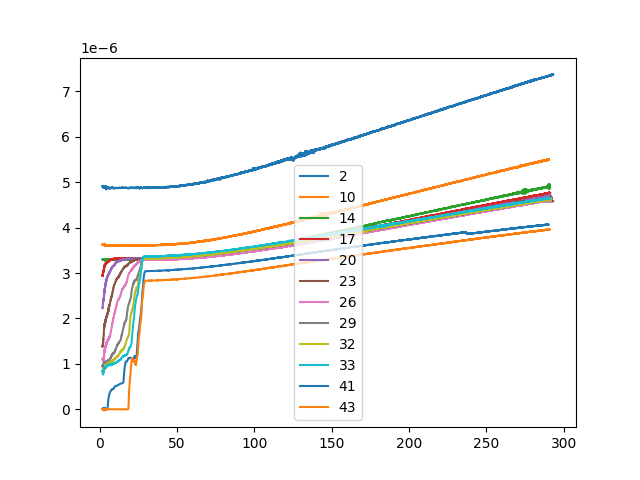

In [20]:
data_dict = {}
path = Path('../data/processed/WarmUp/')
for file in path.iterdir():
    file_num = int(re.split('_', str(file.name))[0])
    data_dict[file_num] = pd.read_csv(
        file,
        delimiter='\t',
        usecols=[2, 3],
        skiprows=[0],
        names=['Temp', 'R']
    ).dropna()
    
fig, ax = plt.subplots()
for file in sorted(data_dict):
    df = data_dict[file]
    print(file)
    df['R_smooth'] = df.R.rolling(100, center=True).mean()
    df = df[df.Temp.diff().abs() < 5]
    ax.plot(df.Temp, df.R_smooth, label=file)
    
ax.legend()

# plt.savefig('../publication_ready/R_vs_T.pdf')

In [13]:
for file, df in data_dict.items():
    R_normal = df.R[df.Temp > 30].iloc[0]
    try:
        print(p_dict[file], df.Temp[df.R > 0.9 * R_normal].iloc[0])
    except:
        pass

143 28.001106


In [15]:
p_dict = {
    '43': 143,
    '41': 130
}
    
p_dict

{'43': 143, '41': 130}

In [ ]:
plt.close('all')

In [ ]:
clear all

In [ ]:
#Importing data files for Loading, Warm up Resistance vs Temperature measurements

In [ ]:
path = '/home/ad.ufl.edu/shubham.sinha/repos/remob2/data/processed/WarmUp/' # path to the files directory
file_list = os.listdir(path) # list of all the files in the directory
fileOrder = [] #initializing an empty list to contain file number chronologically
for file in file_list:
    fileOrder.append(re.split('_',file)[0])
fileOrder =  [int(x) for x in fileOrder]  #Converting the File numbers to integer for sorting

In [ ]:
fileOrder

In [ ]:
lst = zip(fileOrder, file_list)
print([i for i in lst])

In [ ]:
file_list  = [ x for _, x in sorted(zip(fileOrder, file_list))] #Sorting the files list according increasing pressure i.e using fileOrder as sorting parameter

In [ ]:
#file_list1 = sorted(file_list, key = lambda x: int(for i in file_list: re.split('_', i)[0]) #using "key" function to do sorting

In [ ]:
file_list

In [ ]:
#P_bar = ['10','25', '41', '49', '53', '55', '59', '62', '65', '71','74','96']

In [ ]:
data_list = ["df_10bar","df_21bar","df_25bar","df_49bar","df_53bar","df_55bar","df_59bar","df_62bar","df_65bar","df_71bar","df_74bar","df_96bar"] # The numbers correspond to the membrane pressure in bars for each measurement

In [ ]:
Rdf_list= [] # The list of all data file dataframes in order.

In [ ]:
for filename in file_list:
    df_temp = pd.read_csv(r'/home/ad.ufl.edu/shubham.sinha/repos/remob2/data/processed/WarmUp/'+filename,delimiter= "\t")
    Rdf_list.append(df_temp)

In [ ]:
Rdf_list[1].head()

In [ ]:
data_dict = dict(zip(data_list, [None]*len(data_list)))#When you do [None] * n , Python internally creates a list object of size n and it copies the the same object

In [ ]:
#assigning data file dataframe to corresponding dictionary
i=0
for x in data_list:
    data_dict[x] = Rdf_list[i]
    i = i+1

In [ ]:
#plotting resistivity vs temperature
%matplotlib widget
i= 0
fig, ax = plt.subplots()
for i in range(len(Rdf_list)):
    R = Rdf_list[i].iloc[:,3].
    rho = R*1000*((np.pi*10)/np.log(2))*0.0001  #resistivity with units of mOhms-cm.
    ax.plot(Rdf_list[i].iloc[:,2],R)
    i = i+1


plt.show()

In [ ]:
plt.close(fig)


In [ ]:
#plotting with smooted data
%matplotlib widget
i = 0
avg_w = 30; # averaging window
fig, ax = plt.subplots()
for i in range(len(Rdf_list)):
    R = Rdf_list[i].iloc[:,3].rolling(avg_w).mean()
    T = Rdf_list[i].iloc[:,2].rolling(avg_w).mean()
    rho = R*1000*((np.pi*10)/np.log(2))*0.0001  #resistivity with units of mOhms-cm.
    ax.plot(T,R)
    i = i+1


In [ ]:
exit